In [ ]:
%pip install -q transformers accelerate bitsandbytes protobuf sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [1]:
#Initialize Pipeline and Load LLM

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
import torch

# Choose a free model (Falcon is lighter for Colab)
model_name = "tiiuae/falcon-7b-instruct"    # Invoking LLMs
# model_name = "mistralai/Mistral-7B-Instruct-v0.1"
# model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_name = "google/gemma-2-9b-it"
# model_name = "microsoft-Phi-3-small-8k-instruct"
# model_name = "deepseek-ai/Deepseek-R1-Distill-Llama-8B"
# model_name = "01-ai/Yi-1.5-9B-Chat"
# model_name = "internlm/internlm2_5-7b-chat"

# Configure quantization properly (fixes deprecation warning)
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
# Set pad_token if it doesn't exist (fixes the pad_token_id warning)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quantization_config   # Use BitsAndBytesConfig instead of load_in_8bit
)

# Create pipeline with batch processing support
pipe = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer,
    device_map="auto"
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [2]:
def remove_prompt(generated_text, prompt):
    return generated_text.replace(prompt, '').strip()

In [113]:
# Create a list of prompts for batch processing
prompts = [
    "Share possible routes from saddar to gulshan e iqbal",
    "Share possible routes from karachi airport to dha",
    "Share possible routes from johar to clifton",
    "Share possible routes from bahadurabad to saddar",
    "What should I learn for my agentic AI final exam?",
    "Who founded Pakistan?",
    "What is the capital of Pakistan?"
]

# Process the prompts in batches using the pipeline
# The pipeline automatically batches when given a list, maximizing GPU efficiency
results = pipe(
    prompts,
    max_new_tokens=200, 
    do_sample=True, 
    temperature=0.7
)

print("[Accessing without any modification] [Model: %s]" % model_name)
# Extract and clean responses
for i, (prompt, result) in enumerate(zip(prompts, results)):
    if isinstance(result, list):
        generated_text = result[0]['generated_text']
    else:
        generated_text = result['generated_text']
    
    # Remove the prompt from the generated text
    cleaned_response = remove_prompt(generated_text, prompt)
    print(f"\nPrompt {i+1}: {prompt}")
    print(f"Response: {cleaned_response}\n")
    print("-" * 50)

[Accessing without any modification] [Model: tiiuae/falcon-7b-instruct]

Prompt 1: Share possible routes from saddar to gulshan e iqbal
Response: .
I'm sorry, I am an AI language model and do not have access to real-time traffic information. However, you can try using a navigation app like Google Maps or Waze to find the best route from Saddar to Gulshan-i-Iqbal.

--------------------------------------------------

Prompt 2: Share possible routes from karachi airport to dha
Response: city
I'm sorry, as an AI language model, I am not able to provide real-time updates on routes or directions. It is best to consult a reliable public transportation website or app for accurate and up-to-date information.

--------------------------------------------------

Prompt 3: Share possible routes from johar to clifton
Response: The best way to get from Johar to Clifton is by taking a local bus. You can take a bus from Johar to Gulshan-e-Iqbal or Karachi City Bus Terminal and then take a bus from the

Available bus stops: ['malir', 'airport', 'ii chundrigar road', 'liaquatabad', 'nipa', 'nazimabad', 'landhi', 'korangi', 'clifton', 'saddar', 'do darya', 'seaview', 'tariq road', 'orangi', 'gulshan-e-iqbal', 'shahrah-e-faisal']


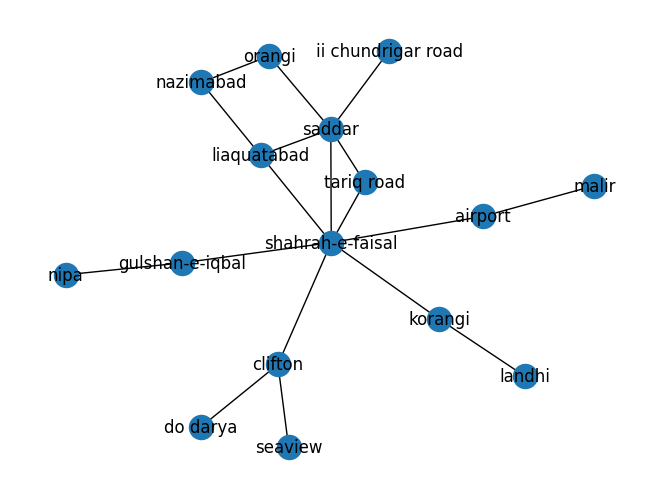

In [114]:
from typing import List, Dict


# Build graph in memory
_BUS_ROUTES_GRAPH = None

def _build_graph() -> Dict[str, List[str]]:
    """Build Karachi bus routes graph in memory as a bidirectional (cyclic) graph."""
    routes = [
        ["saddar", "tariq road", "shahrah-e-faisal", "gulshan-e-iqbal", "nipa"],
        ["nazimabad", "liaquatabad", "shahrah-e-faisal", "clifton", "do darya"],
        ["orangi", "nazimabad", "liaquatabad", "saddar", "ii chundrigar road"],
        ["gulshan-e-iqbal", "shahrah-e-faisal", "clifton", "seaview"],
        ["korangi", "shahrah-e-faisal", "tariq road", "saddar"],
        ["malir", "airport", "shahrah-e-faisal", "saddar"],
        ["landhi", "korangi", "shahrah-e-faisal", "gulshan-e-iqbal"],
        ["saddar", "liaquatabad", "nazimabad", "orangi", "saddar"],
        ["clifton", "shahrah-e-faisal", "gulshan-e-iqbal", "nipa", "gulshan-e-iqbal"],
        ["airport", "shahrah-e-faisal", "tariq road", "saddar", "ii chundrigar road"],
    ]
    
    graph = {}
    for route in routes:
        route = [stop.lower().strip() for stop in route]
        for i in range(len(route) - 1):
            current = route[i]
            next_stop = route[i + 1]
            
            # Initialize nodes if they don't exist
            if current not in graph:
                graph[current] = []
            if next_stop not in graph:
                graph[next_stop] = []
            
            # Add forward edge (current -> next_stop)
            if next_stop not in graph[current]:
                graph[current].append(next_stop)
            
            # Add reverse edge (next_stop -> current) to make it bidirectional
            if current not in graph[next_stop]:
                graph[next_stop].append(current)
    
    return graph


def find_route(source: str, destination: str, depth: int) -> List[List[str]]:
    """
    Find all routes from source to destination with depth limit.
    
    Args:
        source: Starting bus stop (converted to lowercase)
        destination: Target bus stop (converted to lowercase)
        depth: Maximum number of transfers/intermediate stops allowed (prevents infinite loops)
               depth=0 means direct connection, depth=1 means 1 transfer, etc.
        
    Returns:
        List of routes, where each route is a list of stops from source to destination
    """
    global _BUS_ROUTES_GRAPH
    if _BUS_ROUTES_GRAPH is None:
        _BUS_ROUTES_GRAPH = _build_graph()
    
    source = source.lower().strip()
    destination = destination.lower().strip()
    graph = _BUS_ROUTES_GRAPH
    
    # Check if both nodes exist in the graph
    if source not in graph or destination not in graph:
        return []
    
    if source == destination:
        return [[source]]
    
    all_routes = []
    
    def search(current: str, target: str, max_transfers: int, path: List[str], visited: set):
        path.append(current)
        visited.add(current)
        
        if current == target:
            all_routes.append(path.copy())
        elif max_transfers > 0:
            # max_transfers represents remaining transfers allowed
            # We can explore neighbors if we have transfers remaining
            if current in graph:
                for neighbor in graph[current]:
                    if neighbor not in visited:
                        search(neighbor, target, max_transfers - 1, path, visited)
        elif max_transfers == 0:
            # Last transfer: check if destination is directly reachable
            if current in graph and target in graph[current] and target not in visited:
                path.append(target)
                all_routes.append(path.copy())
                path.pop()
        
        path.pop()
        visited.remove(current)
    
    search(source, destination, depth, [], set())
    return all_routes

_BUS_ROUTES_GRAPH = _build_graph()
# function to get all route name as a unique list
def get_all_route_names() -> List[str]:
    return list(set([stop for route in _BUS_ROUTES_GRAPH.values() for stop in route]))

all_route_names = get_all_route_names()
print("Available bus stops:", all_route_names)
# print(find_route("saddar", "gulshan-e-iqbal", 2))

# print tree of graph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph(_BUS_ROUTES_GRAPH)
nx.draw(G, with_labels=True)
plt.show()

In [123]:

import json
import re

def agent_response(user_prompt, override_prompt=None):
    """Agent function that handles route and non-route queries"""
    # Get all available route names for better location matching
    available_stops = get_all_route_names()
    stops_list = ", ".join(available_stops)
    
    # Single unified prompt - model classifies and responds
    ai_prompt = f"""You are an intelligent agent that can handle different types of queries. Classify the query and respond accordingly.

CLASSIFICATION RULES:

ROUTE QUERY - Use TOOL: ROUTE format ONLY when:
- Query explicitly asks about routes, directions, or how to TRAVEL from one location to another
- Query asks "where should I go from" in context of TRAVELING (e.g., "where should I go from if I have to go to X from Y")
- Query is about getting directions or finding a path between two bus stops/locations
- Key indicators: "routes", "directions", "how to get", "way to go", "travel from X to Y"
- Examples: "routes from X to Y", "how to get from X to Y", "where should I go from if I have to go to Y from X"

NON-ROUTE QUERY - Use normal text response when:
- Query asks "What is...", "What should...", "How does...", "Explain...", "Tell me about..."
- Query asks "Where should I..." but NOT about travel/directions (e.g., "Where should I buy...", "Where should I learn...")
- Query is about concepts, definitions, explanations, advice, recommendations, shopping, learning
- Query mentions "from" but NOT in context of travel (e.g., "buy from shop", "learn from book")
- Query does NOT ask about traveling between two specific bus stop locations
- Examples: "What is AI?", "What should I learn?", "Where should I buy books?", "Explain machine learning"

RESPONSE FORMATS:

IF ROUTE QUERY:
Respond EXACTLY in this format (nothing else):
TOOL: ROUTE
{{"source": "location1", "destination": "location2"}}

Available bus stops: {stops_list}
- Extract source and destination from the query (they may appear in any order)
- Match to closest stop name from the list (case-insensitive)
- Use exact stop names from the list
- Handle variations: "gulshan" → "gulshan-e-iqbal", "airport" → "airport"

IF NON-ROUTE QUERY:
- Respond naturally with helpful information
- Do NOT use TOOL: ROUTE
- Do NOT output JSON
- Just provide a normal text response

EXAMPLES:

Example 1 (Route - standard format):
User: "Share possible routes from saddar to gulshan e iqbal"
Agent: TOOL: ROUTE
{{"source": "saddar", "destination": "gulshan-e-iqbal"}}

Example 2 (Route - reversed order):
User: "How can I get to clifton from airport?"
Agent: TOOL: ROUTE
{{"source": "airport", "destination": "clifton"}}

Example 3 (Route - complex phrasing):
User: "where should I go from if I have to go to gulshan from airport"
Agent: TOOL: ROUTE
{{"source": "airport", "destination": "gulshan-e-iqbal"}}

Example 4 (Route - indirect):
User: "I need directions to reach seaview starting from nazimabad"
Agent: TOOL: ROUTE
{{"source": "nazimabad", "destination": "seaview"}}

Example 5 (Non-route - factual):
User: "What is the capital of Pakistan?"
Agent: The capital of Pakistan is Islamabad. It became the capital in 1967, replacing Karachi.

Example 6 (Non-route - educational):
User: "What should I learn for my agentic AI final exam?"
Agent: For your agentic AI final exam, you should focus on understanding agent architectures, tool use, reasoning patterns, prompt engineering, and how LLMs can interact with external systems. Study concepts like ReAct, function calling, and multi-agent systems.

Example 7 (Non-route - explanation):
User: "Explain machine learning"
Agent: Machine learning is a subset of artificial intelligence that enables systems to learn and improve from experience without being explicitly programmed. It uses algorithms to identify patterns in data and make predictions or decisions.

Example 8 (Non-route - "Where should I" but NOT about travel):
User: "Where should I buy better books? is it library from shop?"
Agent: You can buy books from both libraries and shops, but they serve different purposes. Libraries allow you to borrow books for free, while shops let you purchase books to keep. For better selection and new releases, bookshops are usually better. Libraries are great for reading without cost.

CURRENT USER QUERY: "{user_prompt}"

Classify and respond directly. If route query → TOOL: ROUTE format. If non-route query → normal helpful text response.

Agent:"""
    # print(ai_prompt)
    # Use balanced parameters for unified prompt
    temperature = 0.4
    max_tokens = 200
    ai_prompt = override_prompt if override_prompt else ai_prompt

    response = pipe(
        ai_prompt, 
        max_new_tokens=max_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=0.9,
        repetition_penalty=1.5,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )[0]['generated_text']
    
    cleaned_response = remove_prompt(response, ai_prompt).strip()
    
    # Post-processing: Clean up the response based on what model generated
    if cleaned_response.startswith("TOOL: ROUTE"):
        # Model correctly identified route query - extract JSON
        parts = cleaned_response.split("TOOL: ROUTE")
        if len(parts) > 1:
            json_match = re.search(r'\{[^{}]*"source"[^{}]*"destination"[^{}]*\}', parts[1], re.DOTALL)
            if json_match:
                cleaned_response = "TOOL: ROUTE\n" + json_match.group(0)
    elif re.search(r'\{[^{}]*"source"[^{}]*"destination"[^{}]*\}', cleaned_response, re.DOTALL):
        # JSON found but missing TOOL: ROUTE prefix - add it
        json_match = re.search(r'\{[^{}]*"source"[^{}]*"destination"[^{}]*\}', cleaned_response, re.DOTALL)
        cleaned_response = "TOOL: ROUTE\n" + json_match.group(0)

    return cleaned_response



In [138]:
# ============================================================================
# CONFIGURATION: Change these variables to test different routes
# ============================================================================
prompt_source = 'airport'
prompt_destination = 'gulshan'
# Verify the extracted locations match the configured variables
expected_source = 'airport'
expected_dest = 'gulshan-e-iqbal'
# ============================================================================

# Build the route query from the configuration variables
# route_prompt = f"Share possible routes from {prompt_source} to {prompt_destination}"
route_prompt = f"where should I go from if I have to go to {prompt_destination} from {prompt_source}"

print("=" * 60)
print(f"Route Query: {prompt_source.title()} to {prompt_destination.title()}")
print("=" * 60)
print(f"\nUser Query: {route_prompt}")

# Get agent response
route_response = agent_response(route_prompt)
print(f"\nAgent Response:\n{route_response}")

# Parse and validate the response
if route_response.startswith("TOOL: ROUTE"):
    json_match = re.search(r'\{[^{}]*"source"[^{}]*"destination"[^{}]*\}', route_response, re.DOTALL)
    if json_match:
        json_str = json_match.group(0)
        try:
            parsed = json.loads(json_str)
            print(f"\nRoute detected - Valid JSON: {parsed}")
            
            # Extract source and destination from agent response
            extracted_source = parsed.get("source", "").lower().strip()
            extracted_dest = parsed.get("destination", "").lower().strip()
            
            print(f"\n{'='*60}")
            print("Verification:")
            print(f"{'='*60}")
            
            if extracted_source == expected_source:
                print(f"Source correctly extracted: '{extracted_source}'")
            else:
                print(f"Source mismatch!")
                print(f"Expected: '{expected_source}'")
                print(f"Got: '{extracted_source}'")
            
            if extracted_dest == expected_dest:
                print(f"Destination correctly extracted: '{extracted_dest}'")
            else:
                print(f"Destination mismatch!")
                print(f"Expected: '{expected_dest}'")
                print(f"Got: '{extracted_dest}'")
            
            # Find actual routes using the extracted locations
            print(f"\n{'='*60}")
            print(f"Finding routes from '{extracted_source}' to '{extracted_dest}'...")
            print(f"{'='*60}")
            routes = find_route(extracted_source, extracted_dest, depth=10)
            if routes:
                print(f"\nFound {len(routes)} route(s):\n")
                for i, route in enumerate(routes, 1):
                    print(f"Route {i}: {' -> '.join(route)}")
            else:
                print(f"\nNo routes found from '{extracted_source}' to '{extracted_dest}'")
                print(f"Available stops: {', '.join(get_all_route_names())}")

            # generate response from AI in human readable format
            route_prompt = f"User asked for the path from {extracted_source} to {extracted_dest}, and following are paths retrieved from the graph showing start and end points: {routes}\n\nWrite a human readable response for the same routes in a way that is easy to understand"
            response = agent_response('',route_prompt)
            print(f"\nAgent Response:\n{response}")
                
        except json.JSONDecodeError as e:
            print(f"\nRoute detected but JSON invalid: {json_str}")
            print(f"Error: {e}")
    else:
        print("\nRoute detected but JSON not found in response")
else:
    print("\nExpected TOOL: ROUTE format but got different response")


Route Query: Airport to Gulshan

User Query: where should I go from if I have to go to gulshan from airport

Agent Response:
TOOL: ROUTE
{"source": "airport", "destination": "gulshan-e-iqbal"}

Route detected - Valid JSON: {'source': 'airport', 'destination': 'gulshan-e-iqbal'}

Verification:
Source correctly extracted: 'airport'
Destination correctly extracted: 'gulshan-e-iqbal'

Finding routes from 'airport' to 'gulshan-e-iqbal'...

Found 1 route(s):

Route 1: airport -> shahrah-e-faisal -> gulshan-e-iqbal

Agent Response:
.
To get from the airport to Gulshan-e-Iqbal, take these directions: Head towards the airport, then turn left onto Shahr-e-Faisal Boulevard. Continue straight until you reach Gulshan-e-Iqbal Avenue.


In [139]:
# Test with non-route query
print("\n" + "=" * 60)
print("TEST 2: Non-Route Query")
print("=" * 60)
non_route_prompt = "What should I learn for my agentic AI final exam?"
non_route_response = agent_response(non_route_prompt)
print(f"\nUser: {non_route_prompt}")
print(f"\nAgent: {non_route_response}")

if not non_route_response.startswith("TOOL: ROUTE"):
    print("\nDefault reasoning response (non-route query)")
else:
    print("\nExpected default reasoning but got TOOL: ROUTE")



TEST 2: Non-Route Query

User: What should I learn for my agentic AI final exam?

Agent: "The current user should focus on agent architectures, tool use, reasoning patterns, prompt engineering, and how LLMs can interact with external systems. Study concepts like ReAct, function calling, and multi-agent systems."

Default reasoning response (non-route query)


In [135]:
# Test with non-route query
print("\n" + "=" * 60)
print("TEST 3: Non-Route Query")
print("=" * 60)
non_route_prompt = "Where should I buy better books? is it library from shop?"
non_route_response = agent_response(non_route_prompt)
print(f"\nUser: {non_route_prompt}")
print(f"\nAgent: {non_route_response}")

if not non_route_response.startswith("TOOL: ROUTE"):
    print("\nDefault reasoning response (non-route query)")
else:
    print("\nExpected default reasoning but got TOOL: ROUTE")



TEST 3: Non-Route Query

User: Where should I buy better books? is it library from shop?

Agent: "The best place to buy better books would be at a bookstore, as they often have a wider selection and more knowledgeable staff to help you find what you need."

Default reasoning response (non-route query)
